# Analyzing Legislative Burden Upon Businesses Using NLP and ML

### Imports

In [1]:
import spacy
import pandas as pd

In [2]:
# Loads a pipeline (tokenizer, tagger, parser, etc.) of models (English)
nlp = spacy.load('en')

In [3]:
aoda = pd.read_csv('../data/sents_and_titles_w_labels.csv')

In [6]:
aoda.head()

,index,section,text,is_burden,part
0,0,AODA Purpose,Recognizing the history of discrimination agai...,0,INTERPRETATION
1,1,AODA Definitions,"In this Act, “accessibility standard” means an...",0,INTERPRETATION
2,2,AODA Definitions,”) “barrier” means anything that prevents a pe...,0,INTERPRETATION
3,3,AODA Definitions,"(“directeur”) “disability” means, any degree o...",0,INTERPRETATION
4,4,AODA Definitions,“Minister” means the Minister of Citizenship a...,0,INTERPRETATION


## Identify burdens

**Objective**

* Extract sentences that define obligations

**Method**

- The structure of legal texts is relatively rigid and the lexicon is limited.
- No labeled examples, so can't do supervised learning.
- Therefore we implemented rule-based extraction based on a lightweight ontology.

In [7]:
from utils import BURDENS

In [8]:
BURDENS

['shall', 'must', 'ought', 'oblige', 'require']

**WordNet®** is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. Synsets are interlinked by means of conceptual-semantic and lexical relations. The resulting network of meaningfully related words and concepts can be navigated with the [browser](http://wordnetweb.princeton.edu/perl/webwn). WordNet is also freely and publicly available for download.

In [9]:
from nltk.corpus import wordnet

synonyms = []

for w in BURDENS:
    for syn in wordnet.synsets(w, pos='v'):
        for l in syn.lemmas():
            synonyms.append(l.name())

In [15]:
wordnet.synsets('require', pos='v')[0].lemmas()

[Lemma('necessitate.v.01.necessitate'),
 Lemma('necessitate.v.01.ask'),
 Lemma('necessitate.v.01.postulate'),
 Lemma('necessitate.v.01.need'),
 Lemma('necessitate.v.01.require'),
 Lemma('necessitate.v.01.take'),
 Lemma('necessitate.v.01.involve'),
 Lemma('necessitate.v.01.call_for'),
 Lemma('necessitate.v.01.demand')]

In [16]:
synonyms

['compel',
 'oblige',
 'obligate',
 'oblige',
 'bind',
 'hold',
 'obligate',
 'oblige',
 'accommodate',
 'necessitate',
 'ask',
 'postulate',
 'need',
 'require',
 'take',
 'involve',
 'call_for',
 'demand',
 'ask',
 'require',
 'expect',
 'command',
 'require',
 'want',
 'need',
 'require']

The list of verbs in `BURDENS` and `synonyms` define a lightweight ontology, that is used to identify the obligations prescribed by AODA. Given a sentence:
- Extract lemma from each term
- If any of the lemmas appears in the ontology, add the sentence to the list of burdens

In [17]:
# nlp is the Spacy model - we are using the lemmatizer here to compare to our ontology.
aoda['tagged_as_burden'] = aoda.text\
    .map(lambda sent: any([True for token in nlp(sent) if token.lemma_ in BURDENS + synonyms]))

### Evaluation

In [18]:
aoda.is_burden.sum()

423

In [19]:
aoda['tagged_as_burden'].sum()

539

* Accuracy

In [20]:
(aoda.is_burden == aoda.tagged_as_burden.astype(int)).sum()/len(aoda)

0.8853288364249579

* TP: True Positive Rate
* FP: False Positive Rate
* FN: False Negative Rate

In [22]:
TP = ((aoda.is_burden == 1) & (aoda.tagged_as_burden == True)).sum()
FP = ((aoda.is_burden == 0) & (aoda.tagged_as_burden == True)).sum()
FN = ((aoda.is_burden == 1) & (aoda.tagged_as_burden == False)).sum()

* Precision: \$\frac{TP}{TP + FP}$

In [23]:
TP / (TP + FP)

0.7662337662337663

Eaxmple of a sentence incorrectly classified as a burden

In [24]:
aoda.iloc[17]

index                                                              17
section                                 AODA Application of standards
text                An accessibility standard shall name or descri...
is_burden                                                           0
part                                          ACCESSIBILITY STANDARDS
tagged_as_burden                                                 True
Name: 17, dtype: object

In [25]:
aoda.iloc[17]['text']

'An accessibility standard shall name or describe the persons or organizations to which it applies.'

* Recall: \$\frac{TP}{TP + FN}$

In [26]:
TP / (TP + FN)

0.9763593380614657

Example of a burden that isn't extracted by our method

In [27]:
aoda.iloc[33]

index                                                              33
section                     AODA Process for development of standards
text                The Minister is responsible for establishing a...
is_burden                                                           1
part                                          ACCESSIBILITY STANDARDS
tagged_as_burden                                                False
Name: 33, dtype: object

In [28]:
aoda.iloc[33]['text']

'The Minister is responsible for establishing and overseeing a process to develop and implement all accessibility standards necessary to achieving the purposes of this Act.'

## Identify the subjects of the burdens

### Objective

- Extract the subjects of the burdens
- Organize burdens into homogeneous groups based on the entities they affect, e.g. public VS private

Spacy will tag the subject with different subject tags depending upon the syntactic context, e.g. passive vs active; nominal vs clausal.

Dependency parsing tags for sentence subjects:

* `nsubj`: nominal subject ('the `cat` is in the box'),
* `nsubjpass`: passive nominal subject ('a safety `video` will be played before take-off'),
* `csubj`: clausal subject (a clausal syntactic subject of a clause, e.g. '**what you** `say` makes sense'),
* `csubjpass`: clausal passive subject (a clausal syntactic subject of a passive clause, '**that she** `lied` was suspected by everyone'),
* `agent`: link between a passive participle and the by-PP introducing its agent ('the door was opend by `him`'),
* `expl`: expletive ('`there` is a ghost in the room')

**Each standards development committee** shall develop proposed accessibility standards in accordance with the process set out in this section.

Each standards development **committee** shall develop proposed accessibility standards in accordance with the process set out in this section.

In [29]:
from spacy import displacy

In [30]:
sent = nlp('Each standards development committee shall develop proposed accessibility standards in accordance with the process set out in this section.')

In [31]:
displacy.render(sent, style='dep', jupyter=True)

#### Solution

- Combine tags assigned by the Dependency Parser with Breadth First Search
- Navigate the dependency tree and identify the subset of tokens that are related to the subject by a parent-child relationship

In [32]:
from utils import bfs, SUBJECTS

In [33]:
SUBJECTS

['nsubj', 'nsubjpass', 'csubj', 'csubjpass', 'agent', 'expl']

In [34]:
sent = nlp('Each standards development committee shall develop proposed accessibility standards in accordance with the process set out in this section.')

* Extract the verbs that express an obligation

In [35]:
verbs =  [token.head if token.tag_ == 'MD' else token for token in sent if token.lemma_ in BURDENS]

In [36]:
verbs

[develop]

* Extract all tokens associated with one of the tags in SUBJECTS

In [37]:
all_tokens = [token for token in sent if token.dep_ in SUBJECTS]

In [39]:
bag_of_words = []

for token in all_tokens:
        bag_of_words += bfs(token)

In [40]:
' '.join([t.text for t in sorted(bag_of_words, key=lambda t: t.i)])

'Each standards development committee'

In [41]:
from utils import make_sentence

In [42]:
df = pd.DataFrame(
        list(
            aoda[aoda.tagged_as_burden][['index', 'section', 'text', 'part']]\
                .apply(lambda row: make_sentence(row['index'], nlp(row['text']), row['section'], row['part']),
                       axis=1)
    )
)

In [44]:
df.tail()

,sid,section,part,text,subj,v,obj
534,1172,REG Payment of penalty,COMPLIANCE,The person or organization that has been order...,The person or organization that that has been ...,[pay],an administrative penalty the penalty
535,1173,REG Payment of penalty,COMPLIANCE,Where a person or organization that has been o...,a person or organization that that has been or...,[pay],an administrative penalty a review of the orde...
536,1174,REG Payment of penalty,COMPLIANCE,"For the purposes of subsection , where a perso...",a person or organization both the administrati...,[paid],a review of the order the order
537,1176,REG Accessibility reports,COMPLIANCE,86.1 Subject to subsections 33 and of the A...,organizations,"[file, required]",the accessibility report required under subsec...
538,1185,REG Accessibility reports,COMPLIANCE,"Subject to subsections 33 and of the Act, or...",organizations that that every three years foll...,"[file, required, required]",the accessibility report required under subsec...


In [48]:
df.iloc[-5]

'The person or organization that has been ordered to pay an administrative penalty shall pay the penalty within 30 days after the order was made, unless a longer period is specified in the order.    '

## Grouping subjects

**Objective**

- Aim to find natural grouping of subjects by type, based on linguistic patterns

**Method**

- Normalize
- Project subjects into a semantic space ([GloVe](https://nlp.stanford.edu/projects/glove/))
- Reduce dimensionality
- KMeans clustering

#### Normalization / Lemmatization

* STOPWORDS is the combination of nltk + spacy stopwords, enriched with some words that were frequent in AODA, e.g. section/subsection

In [49]:
from utils import STOPWORDS

In [50]:
df['s_norm'] = df.subj.apply(
    lambda subj: [t.lemma_ for t in nlp(subj) if t.is_alpha and t.lemma_ not in STOPWORDS]
)

#### Project into GloVe space

Reading **GloVe** vectors:

If missing, add shape of vectors as first line, i.e. 400000 50, then, on command line:

In [51]:
!python -m spacy init-model en /tmp/vectors --vectors-loc ../data/glove.6B.50d.txt.zip

Reading vectors from ../data/glove.6B.50d.txt.zip
Open loc
400000it [00:08, 46211.55it/s]
Creating model...
0it [00:00, ?it/s]

    Sucessfully compiled vocab
    399842 entries, 400000 vectors



In [52]:
glove50 = spacy.load('/tmp/vectors')

In [53]:
import numpy as np

def glove_projection(tokens):
    vectors = [glove50(token).vector for token in tokens]
    return np.mean(vectors, axis=0) if tokens else np.zeros(50)

In [54]:
df['subj_vector'] = df.s_norm.map(glove_projection)

In [55]:
df = pd.concat([
    df,
    pd.DataFrame(df.s_norm.map(glove_projection).tolist(),
                 columns=['s{}'.format(i) for i in range(50)])
], axis=1)

In [56]:
df.shape

(539, 59)

In [57]:
df.head()

,sid,section,part,text,subj,v,obj,s_norm,subj_vector,s0,...,s40,s41,s42,s43,s44,s45,s46,s47,s48,s49
0,3,AODA Definitions,INTERPRETATION,"(“directeur”) “disability” means, any degree o...",( “ directeur ” ) “ disability ” that by bodil...,[],the generality of the foregoing diabetes melli...,"[directeur, disability, bodily, injury, benefit]","[0.2628346, 0.23559415, -0.5389972, -0.1731066...",0.262835,...,-0.016954,-0.317374,-0.123995,0.770236,-0.090187,-0.600568,-0.100497,0.311346,0.577616,0.208082
1,4,AODA Definitions,INTERPRETATION,“Minister” means the Minister of Citizenship a...,“ Minister ” the administration of this Act ” ...,[requires],the Minister of Citizenship and Immigration or...,"[minister, administration, act, regulation, pr...","[-0.217507, -0.23675714, -0.44891858, -0.02644...",-0.217507,...,-0.388910,0.047204,0.203163,0.110629,-0.263456,0.187128,-0.341851,0.608143,0.603104,0.369730
2,13,AODA Crown bound,APPLICATION,This Act binds the Crown.,This Act,[],the Crown,[act],"[-0.60647, -0.65705, -1.1819, -0.61002, -0.197...",-0.606470,...,-0.799890,-0.693810,0.374690,-0.017377,-0.882460,0.257600,-0.983790,-0.559320,0.588230,0.737530
3,17,AODA Application of standards,ACCESSIBILITY STANDARDS,An accessibility standard shall name or descri...,An accessibility standard it,[name],the persons or organizations to which it applies,"[accessibility, standard]","[-0.62898004, 0.51316, 0.13571, -0.0933535, -0...",-0.628980,...,0.662865,-0.401706,0.454295,0.758150,-0.606560,-0.011465,0.485610,0.397945,0.746325,0.363160
4,27,AODA Content of standards,ACCESSIBILITY STANDARDS,"An accessibility standard shall, set out measu...",An accessibility standard,"[shall, require]","measures , policies , practices or other requi...","[accessibility, standard]","[-0.62898004, 0.51316, 0.13571, -0.0933535, -0...",-0.628980,...,0.662865,-0.401706,0.454295,0.758150,-0.606560,-0.011465,0.485610,0.397945,0.746325,0.363160


#### Dimensionality Reduction

In [58]:
from sklearn.manifold import SpectralEmbedding

In [59]:
n_dim = 2
embeddings = SpectralEmbedding(n_components=n_dim)

In [60]:
subjects = pd.DataFrame(
    embeddings.fit_transform(df[['s{}'.format(i) for i in range(50)]]),
    columns=['x{}'.format(i) for i in range(n_dim)])

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

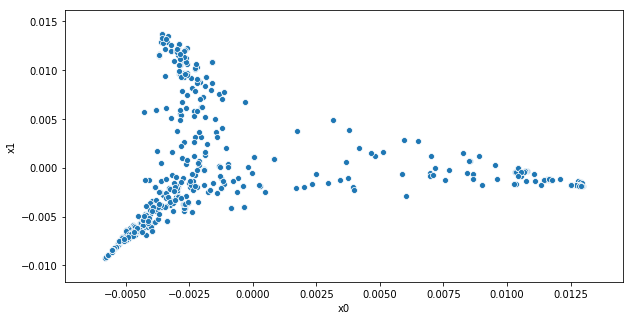

In [62]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=subjects, x='x0', y='x1')

#### Kmeans

In [63]:
from sklearn.cluster import KMeans

#### Elbow method

In [64]:
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k).fit(subjects)
    inertia.append(km.inertia_)

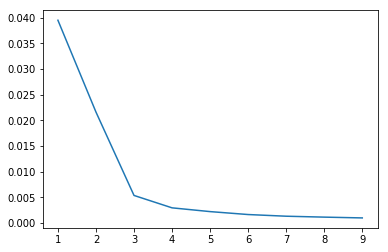

In [65]:
sns.lineplot(x=range(1, 10), y=inertia)

In [66]:
n_groups = 3
km = KMeans(n_clusters=n_groups, random_state=0).fit(subjects)

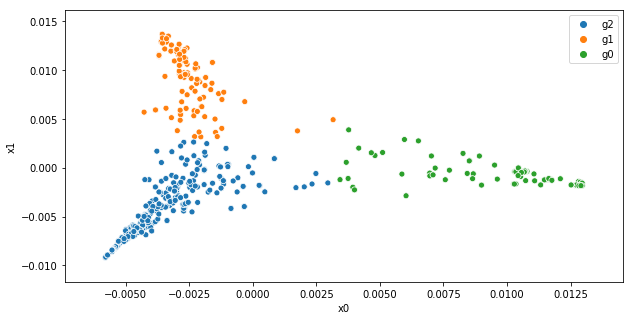

In [67]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=subjects, x='x0', y='x1', hue=['g{}'.format(label) for label in km.labels_])

## Visualizing the groups

* Analyze the groups in terms of word freqeuncy distributions

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

from utils import LemmaTokenizer, combined_plots

In [69]:
counter = CountVectorizer(tokenizer=LemmaTokenizer())
counter.fit(df.subj)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<utils.LemmaTokenizer object at 0x146d33f28>,
        vocabulary=None)

* transform sentences using CountVectorizer

In [70]:
subj = pd.DataFrame(
    counter.fit_transform(df['subj'].astype(str)).toarray(),
    columns=counter.get_feature_names()
)

* add groups labels

In [71]:
subj['label'] = km.labels_

* aggregate frequences at group level

In [72]:
groups = pd.melt(
    subj.groupby('label').sum().reset_index(),
    id_vars='label', var_name='word', value_name='count'
).groupby('label').apply(lambda group: group.sort_values(by='count', ascending=False)).reset_index(drop=True)

* rank by frequency

In [73]:
groups['rank'] = groups.groupby('label')['count'].rank(method='first', ascending=False)

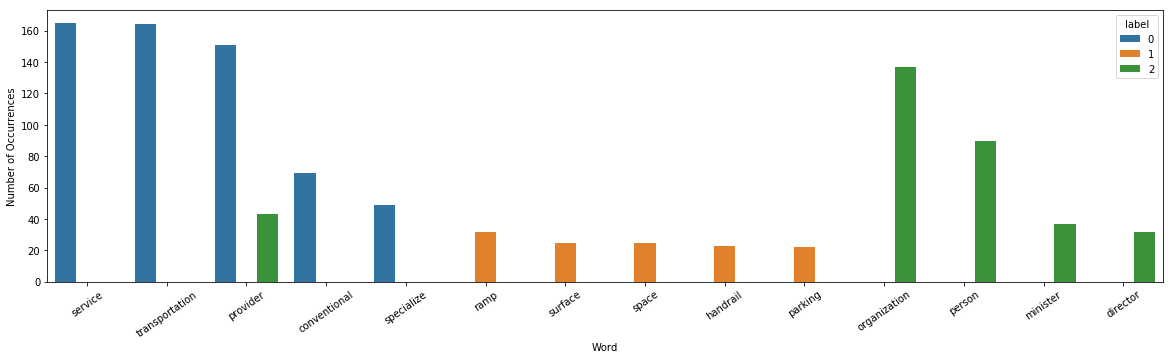

In [74]:
plt.figure(figsize=(20,5))
sns.barplot(data=groups[groups['rank'] <= 5], x='word', y='count', hue='label')
plt.xticks(rotation=35)
plt.xlabel('Word')
plt.ylabel('Number of Occurrences')
plt.show();

#### Group 0

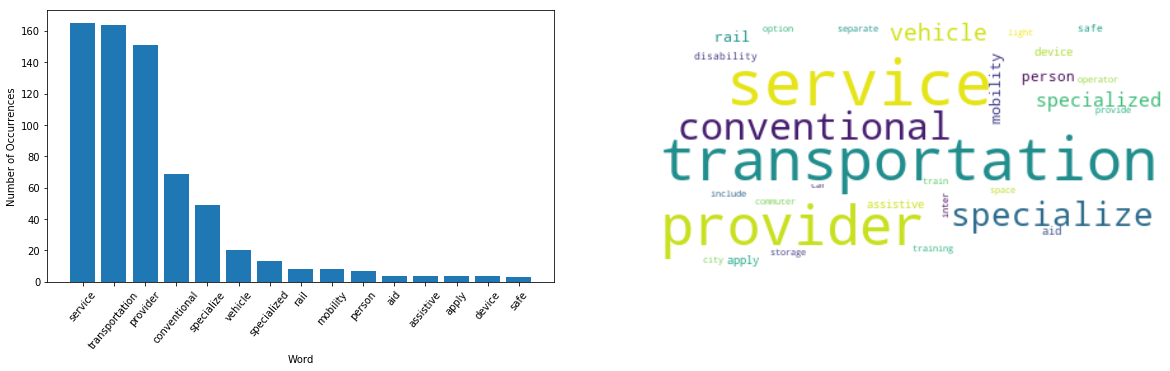

In [75]:
combined_plots(groups, label=0, max_rank=15, max_words=30)

Proportion of burdens in this group

In [76]:
(km.labels_ == 0).sum() / len(km.labels_)

0.21335807050092764

Distribution across sections

In [77]:
pd.DataFrame(df[km.labels_ == 0]['part'].value_counts() / (km.labels_ == 0).sum())

,part
TRANSPORTATION STANDARDS,0.921739
DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILITY STANDARDS FOR THE BUILT ENVIRONMENT),0.069565
GENERAL,0.008696


#### Group 1

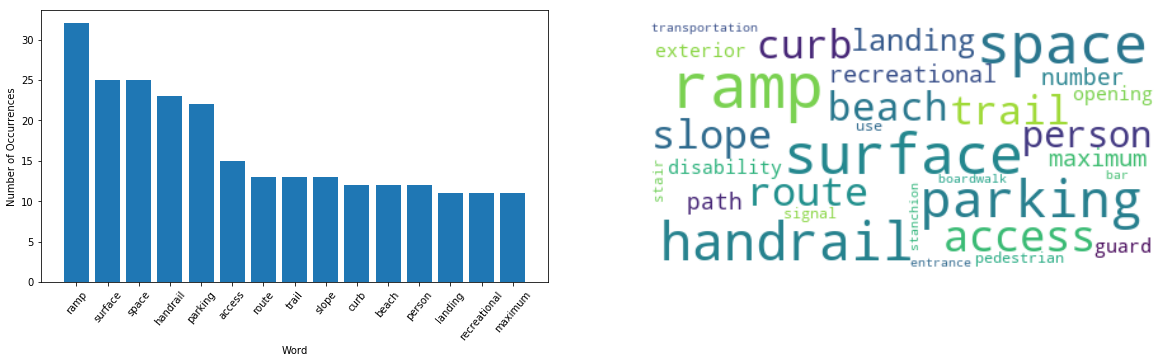

In [78]:
combined_plots(groups, label=1, max_rank=15, max_words=30)

Proportion of burdens in this group

In [79]:
(km.labels_ == 1).sum() / len(km.labels_)

0.2541743970315399

Distribution across sections

In [80]:
pd.DataFrame(df[km.labels_ == 1]['part'].value_counts() / (km.labels_ == 1).sum())

,part
DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILITY STANDARDS FOR THE BUILT ENVIRONMENT),0.802920
TRANSPORTATION STANDARDS,0.138686
COMPLIANCE,0.014599
DIRECTOR’S ORDERS AND ADMINISTRATIVE PENALTIES,0.014599
ACCESSIBILITY STANDARDS,0.014599
EMPLOYMENT STANDARDS,0.007299
ADMINISTRATION,0.007299


#### Group 2

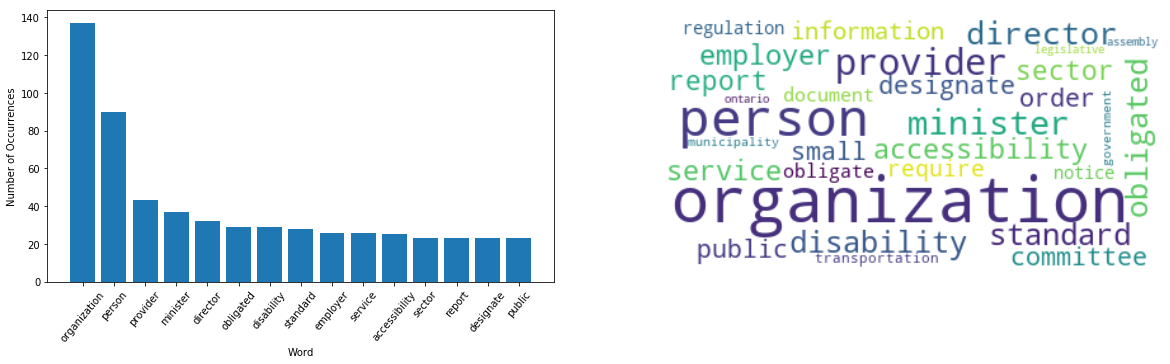

In [81]:
combined_plots(groups, label=2, max_rank=15, max_words=30)

Proportion of burdens in this group

In [82]:
(km.labels_ == 2).sum() / len(km.labels_)

0.5324675324675324

Distribution across sections

In [83]:
pd.DataFrame(df[km.labels_ == 2]['part'].value_counts() / (km.labels_ == 2).sum())

,part
DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILITY STANDARDS FOR THE BUILT ENVIRONMENT),0.205575
GENERAL,0.132404
TRANSPORTATION STANDARDS,0.125436
INFORMATION AND COMMUNICATIONS STANDARDS,0.118467
ACCESSIBILITY STANDARDS,0.094077
EMPLOYMENT STANDARDS,0.083624
COMPLIANCE,0.062718
INSPECTIONS,0.041812
DIRECTOR’S ORDERS AND ADMINISTRATIVE PENALTIES,0.038328
APPEALS TO TRIBUNAL,0.031359


## Topic Analysis

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation

In [85]:
pipeline = Pipeline([
    ('counts', CountVectorizer(max_features=50, tokenizer=LemmaTokenizer())),
    ('lda', LatentDirichletAllocation(n_components=n_groups, learning_decay=0.5, max_iter=10, random_state=1))
])

In [86]:
pipeline.fit(df.subj)

Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...           random_state=1, topic_word_prior=None,
             total_samples=1000000.0, verbose=0))])

In [87]:
vectorizer = pipeline.named_steps['counts']
dtm = vectorizer.fit_transform(df.subj)

In [88]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [89]:
p = pyLDAvis.sklearn.prepare(pipeline.named_steps['lda'], dtm, vectorizer)

/Users/serena/.virtualenvs/gov-on/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [90]:
pyLDAvis.display(p)

**Further analysis**

* Refine preprocessing, e.g. extend the list of stopwords to include words like organizations
* Analyse the objects of the sentences